In [6]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
#import imageio.v2 as imageio

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [7]:
# 데이터셋의 경로
dataroot = "/home/work/CPS_Project/CPS_Project-main/images/FFHQ"

# dataloader에서 사용할 쓰레드 수
workers = 4

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지들은 transformer를 이용해 64로 크기가 통일됩니다.
image_size = 64

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 100

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

Files already downloaded and verified
cuda:0 is available!


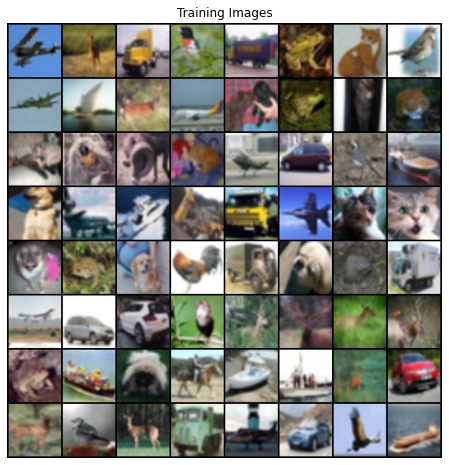

In [8]:
# 우리가 설정한 대로 이미지 데이터셋을 불러와 봅시다
# 먼저 데이터셋을 만듭니다
'''
# FFHQ dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.CenterCrop(image_size),
                               T.ToTensor(),
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
'''
#CIFAR10 dataset
transforms = T.Compose([
    T.Resize(64),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
train_dataset = dset.CIFAR10(root='./data', train=True, transform=transforms, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device,"is available!")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
transform = T.Compose([
    T.Resize((299,299)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = dset.CIFAR10(root='./data', train=True, transform=transform, download=True)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [ ]:
transform = T.Compose([
    T.Resize((299,299)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = dset.CIFAR10(root='./data', train=True, transform=transform, download=True)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [ ]:
transform = T.Compose([
    T.Resize((299,299)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = dset.CIFAR10(root='./data', train=True, transform=transform, download=True)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [ ]:
transform = T.Compose([
    T.Resize((299,299)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = dset.CIFAR10(root='./data', train=True, transform=transform, download=True)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [9]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [13]:
# 구분자를 만듭니다
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# Create instance of BCELoss function
criterion = nn.BCELoss()

# Create a latent space vector to check the generator's learning state
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Set true/false labels used for training
real_label = 1.
fake_label = 0.

# Create an Adam optimizer for use in G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [47]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if (epoch + 1) % 25 == 0:
        torch.save(netG.state_dict(), f'CIFAR10_model/generator_model_epoch_{epoch+1}.pth')
        torch.save(netD.state_dict(), f'CIFAR10_model/discriminator_model_epoch_{epoch+1}.pth')

Starting Training Loop...
[0/100][0/391]	Loss_D: 1.6338	Loss_G: 5.7541	D(x): 0.5268	D(G(z)): 0.5231 / 0.0048
[0/100][50/391]	Loss_D: 0.0168	Loss_G: 24.7028	D(x): 0.9857	D(G(z)): 0.0000 / 0.0000
[0/100][100/391]	Loss_D: 0.0010	Loss_G: 41.7268	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[0/100][150/391]	Loss_D: 0.0005	Loss_G: 41.6803	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/100][200/391]	Loss_D: 0.0004	Loss_G: 41.4312	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/100][250/391]	Loss_D: 0.0003	Loss_G: 41.3396	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/100][300/391]	Loss_D: 0.0001	Loss_G: 41.2643	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/100][350/391]	Loss_D: 0.0001	Loss_G: 41.1397	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/100][0/391]	Loss_D: 0.0001	Loss_G: 40.9764	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/100][50/391]	Loss_D: 0.0001	Loss_G: 40.8741	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/100][100/391]	Loss_D: 0.0001	Loss_G: 41.0551	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/100][150/391]	Loss_D: 0.0000	Los

NameError: name 'G_losses' is not defined

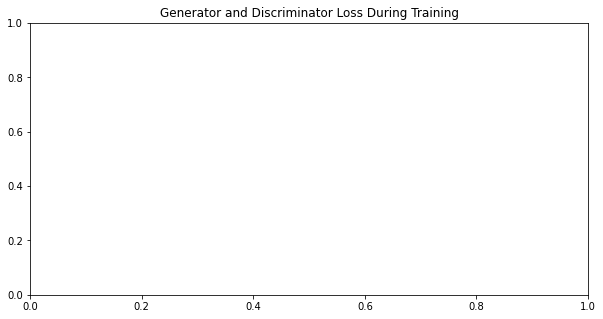

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

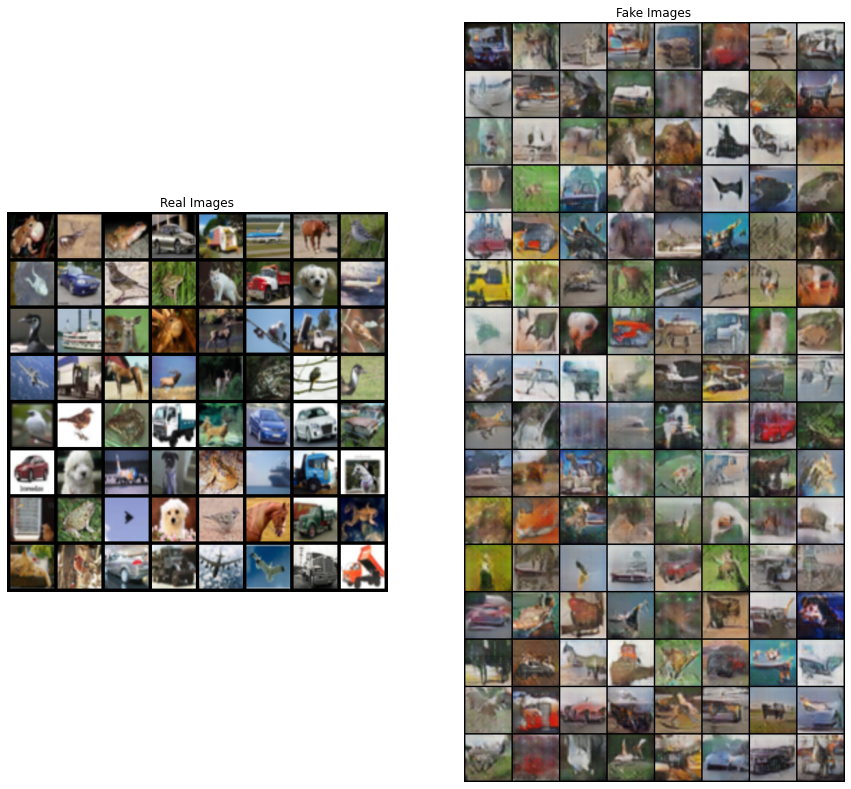

In [49]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(train_loader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### 이미지 샘플링

In [17]:
# After training, you can generate some samples using the trained generator
from torchvision.utils import save_image

# 모델을 로드합니다
netG = Generator(ngpu).to(device)  # Generator 클래스의 인스턴스를 생성합니다. 필요한 인자가 있다면 제공해야 합니다.
netG.load_state_dict(torch.load('CIFAR10_model/generator_model_epoch_100.pth'))
netG.to(device)
netG.eval()  # 모델을 평가 모드로 설정합니다. 이렇게 하면 dropout이나 batchnorm 같은 레이어들이 학습 모드에서와는 다르게 동작합니다.

with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = netG(fixed_noise)
    save_image(fake_images, 'fake_images.png')

In [34]:
# 1. fake_image 디렉토리 생성
if not os.path.exists('fake_image_CIFAR10/fake_image'):
    os.makedirs('fake_image_CIFAR10/fake_image')

# 2. 가짜 이미지 생성 및 fake_image 디렉토리에 저장
required_batches = 60000 // batch_size  # 필요한 배치 수 계산
for batch_num in range(required_batches):
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    with torch.no_grad():
        fake = netG(noise)
    for image_num, image in enumerate(fake):
        vutils.save_image(image, f'fake_image_CIFAR10/fake_image/fake_{batch_num * batch_size + image_num}.png', normalize=True)
        

KeyboardInterrupt: 

### FID Evaluation

In [35]:
from torchvision.models import inception_v3

# Inception 모델 로딩
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval();


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
def get_features(data_loader, model):
    all_features = []
    for images, _ in data_loader:
        with torch.no_grad():
            features = model(images.to(device))
        all_features.append(features.cpu().numpy())
    return np.concatenate(all_features, axis=0)


In [40]:
# FID 계산
from scipy.linalg import sqrtm

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


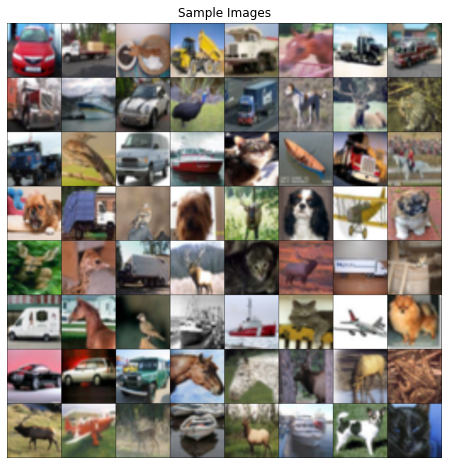

In [41]:
# 몇 개의 샘플 이미지를 시각화합니다.
sample_batch = next(iter(real_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [44]:
# 1. 실제 데이터셋에 대한 Dataloader 생성
transform = T.Compose([
    T.Resize((299,299)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = dset.CIFAR10(root='./data', train=True, transform=transform, download=True)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=batch_size, shuffle=True)

# 2. 가짜 데이터셋에 대한 Dataloader 생성
fake_dataset = dset.ImageFolder(root = 'fake_image_CIFAR10', transform=transform)
fake_dataloader = torch.utils.data.DataLoader(fake_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [45]:
# 실제 데이터와 생성된 데이터의 특징 벡터를 추출
real_features = get_features(real_dataloader, inception_model)
fake_features = get_features(fake_dataloader, inception_model)

# FID 계산
fid_value = calculate_fid(real_features, fake_features)
print("FID:", fid_value)


FID: 259.38867703708195
